# Egocentric CPR Rate Result Calculation

In [ ]:
!pip install pandas
!pip install seaborn

In [6]:
import pandas as pd
import re

# Define file paths
results_log_path = './results/unsupervised_ego_rate_window_test_split_results.txt'
output_csv_path = './results/egocentric_unsupervised_cpr_rate_subject_summary.csv'

# Load and parse log data
all_results = []
with open(results_log_path, 'r') as f:
    for line in f:
        match = re.search(r"File:((P\d+|ng\d+|wa\d+|ms\d+))_(t\d+|ts\d+)_.*?_keypoints\.json,Window:(\d+),Predicted_CPR_Rate:([\d.]+),GT_CPR_Rate:([\d.]+),InferenceTimeSeconds:([\d.]+)", line)
        if match:
            subject = match.group(1)  # Extract subject ID (PX or ngX)
            trial = match.group(3)    # Extract trial ID (tX or tsX)
            window = int(match.group(4))
            predicted_cpr_rate = float(match.group(5))
            gt_cpr_rate = float(match.group(6))
            inference_time = float(match.group(7))
            error = abs(gt_cpr_rate - predicted_cpr_rate)
            all_results.append([subject, gt_cpr_rate, predicted_cpr_rate, error, inference_time])

# Create DataFrame
df = pd.DataFrame(all_results, columns=['Subject', 'GT CPR Rate', 'Predicted CPR Rate', 'Error', 'Inference Time'])

# Calculate averages per subject
summary_df = df.groupby('Subject').agg({
    'GT CPR Rate': 'mean',
    'Predicted CPR Rate': 'mean',
    'Error': 'mean',
    'Inference Time': 'mean'
}).reset_index()

# Rename columns for clarity
summary_df.columns = ['Subject', 'Average GT CPR Rate', 'Average Predicted CPR Rate', 'Average Error', 'Average Inference Time']

# Save to CSV
summary_df.to_csv(output_csv_path, index=False)

print(f'Analysis complete. Results saved to {output_csv_path}.')


Analysis complete. Results saved to ./results/egocentric_unsupervised_cpr_rate_subject_summary.csv.


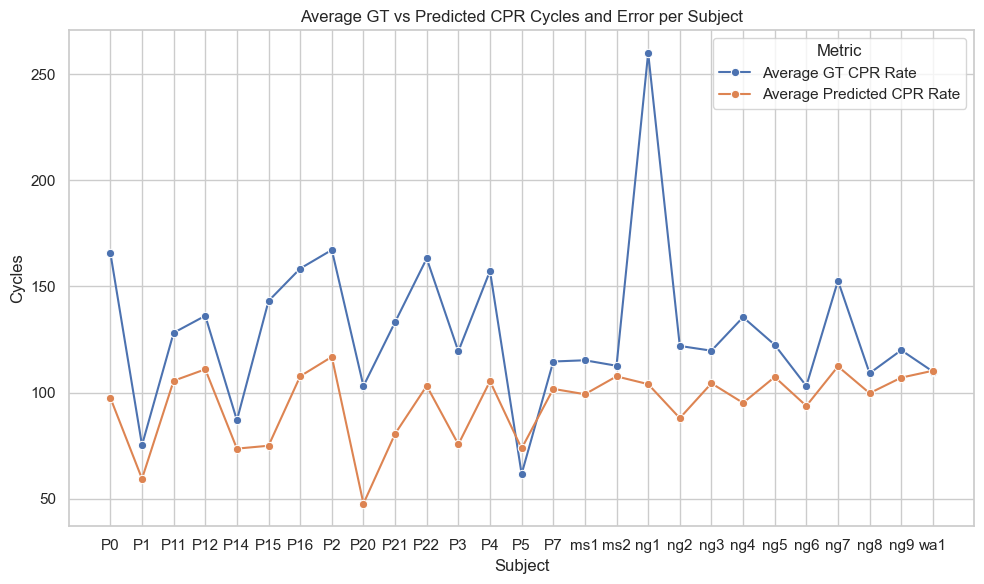

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(output_csv_path)

# Set up the plot style
sns.set(style="whitegrid")

# # Melt the DataFrame to use in Seaborn
# melted_df = summary_df.melt(id_vars='Subject', 
#                             value_vars=['Average GT CPR Rate', 'Average Predicted CPR Rate', 'Average Error'],
#                             var_name='Metric', value_name='Cycles')

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR Rate', 'Average Predicted CPR Rate'],
                            var_name='Metric', value_name='Cycles')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x='Subject', y='Cycles', hue='Metric', marker="o")

# Add plot labels and title
plt.title('Average GT vs Predicted CPR Cycles and Error per Subject')
plt.xlabel('Subject')
plt.ylabel('Cycles')

# Display the plot
plt.tight_layout()
plt.show()


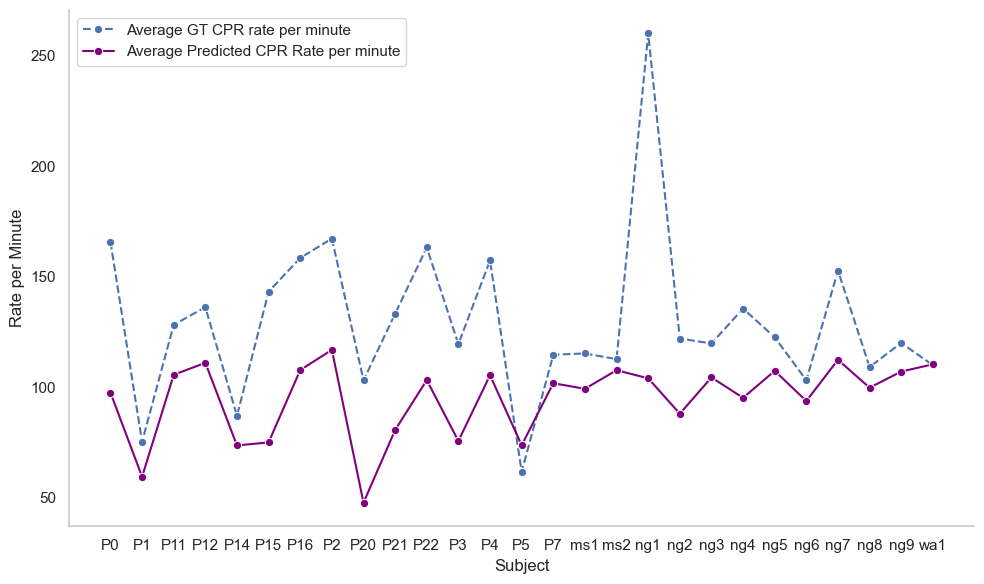

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(output_csv_path)

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR Rate', 'Average Predicted CPR Rate'],
                            var_name='Metric', value_name='Rate')

# Create the line plot with customized style
plt.figure(figsize=(10, 6))

# Plot GT rate with dashed line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average GT CPR Rate'], 
    x='Subject', y='Rate', label='Average GT CPR rate per minute', 
    linestyle='--',  marker="o"
)

# Plot Predicted rate with solid purple line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average Predicted CPR Rate'], 
    x='Subject', y='Rate', label='Average Predicted CPR Rate per minute', 
    linestyle='-', color='purple', marker="o"
)

# Add plot labels and title
# plt.title('Average GT vs Predicted CPR Cycles per Minute per Subject')
plt.xlabel('Subject')
plt.ylabel('Rate per Minute')

sns.despine()

# Disable grid
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()


# Compare smartwatch cpr rate and vision rate

   participant   GT_Depth  Pred_Depth  Depth_error  GT_CPR_rate  \
0           P0  29.537883   29.650041     7.978208    11.589623   
1           P1  41.687441   40.155937     9.633898     8.771186   
2          P11  29.511459   30.055126    11.039886    11.409091   
3          P12  19.084786   30.689360    11.838481    10.518987   
4          P14  41.351939   35.556689    14.586923     8.942308   
5          P15  24.935938   29.564955     7.526154    10.551282   
6          P16  27.369919   30.898963     9.864500    12.687500   
7           P2  24.147902   40.638144    16.490755    14.254717   
8          P20  27.027362   29.298826     7.573444     9.977778   
9          P21  28.621427   30.661842    13.206700    10.640000   
10         P22  12.798503   29.439477    16.640400    13.440000   
11          P3  41.970961   34.083512    13.475342    10.904110   
12          P4  34.745326   42.135338    13.461286    14.142857   
13          P5  32.104781   30.935657     9.191875     8.90625

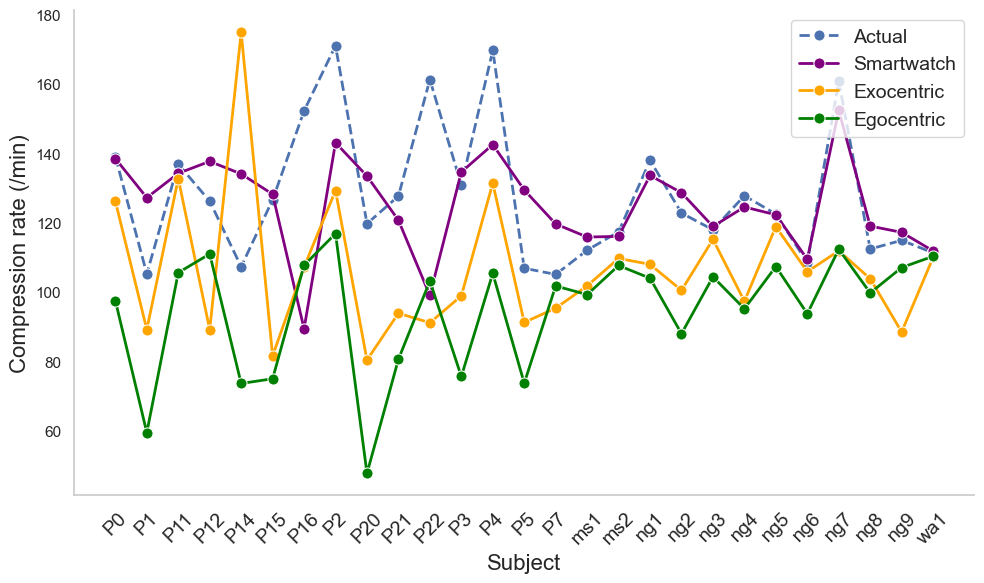

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

egocentric_data = summary_df

# Load the smartwatch CSV data into a DataFrame
smartwatch_data = pd.read_csv("../smartwatch/averages_output.csv")
# Load the exocentric vision summary data
vision_data = pd.read_csv('./outlier_depth_window_subject_summary.csv')
# Load the egocentric vision summary data
egocentric_vision_data = pd.read_csv(output_csv_path)

# Merge the data on the participant/subject column
merged_data = pd.merge(
    smartwatch_data,
    vision_data.rename(columns={'Subject': 'participant'}), 
    on='participant', 
    how='inner'
)

merged_data = pd.merge(
    merged_data,
    egocentric_data.rename(columns={'Subject': 'participant'}), 
    on='participant', 
    how='inner'
)

print(merged_data)

# Create directory for saving plots
results_plots = './result_plots'
os.makedirs(results_plots, exist_ok=True)

# Set plot style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot GT CPR Rate, Smartwatch Predicted CPR Rate, and Vision Predicted CPR Rate
sns.lineplot(x='participant', y='GT_CPR_rate_per_min', data=merged_data, marker='o', label='Actual', color='b', linestyle='--', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Keshara_Low_Pass_Pred_CPR_rate_per_min', data=merged_data, marker='o', label='Smartwatch', color='purple', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Average Predicted CPR cycles per min', data=merged_data, marker='o', label='Exocentric', color='orange', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Average Predicted CPR Rate', data=merged_data, marker='o', label='Egocentric', color='green', linewidth=2, markersize=8)

# Customize plot
plt.xlabel("Subject", fontsize=16)
plt.ylabel("Compression rate (/min)", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.grid(False)
sns.despine()
plt.tight_layout()

# Save and show plot
plt.savefig(f'{results_plots}/CPR_Rate_Comparison_with_Vision.png')
plt.show()


